<div style="border: 2px solid #f0f0f0; padding: 10px; border-radius: 5px; background-color: #f9f9f9; font-size: 16px; color: #000000;">
<b>We identify patients with specific genetic mutations, including GBA, LSNCA, and LLRRK2, as well as individuals who were prescribed dopaminergic medications either at baseline or before.</b>
</div>


In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from datetime import datetime

In [2]:
path1 = Path("/home/znazari/data") 
path2=Path("/scratch/znazari/PPMI_ver_sep2022/study_data/Subject_Characteristics/")
path3= Path("/scratch/znazari/PPMI_ver_sep2022/study_data/Medical_History")

#  Patients with Mutation Genes (GBA, LSNCA, LLRRK2) 
CONGBA,CONSNCA, and CONLRRK2 are genes mutation per **Con**sensus Committee

In [3]:
# reading the file which contains diagnosis
diago=pd.read_csv(path2/"Participant_Status.csv", header=None )
diago1=diago.rename(columns=diago.iloc[0]).drop(diago.index[0]).reset_index(drop=True)

#Patients who have the mutations
selected_rows = diago1[(diago1["CONGBA"] == "1")|(diago1["CONSNCA"] == "1")|(diago1["CONLRRK2"] == "1")]

In [4]:
#Saving the lsit of patient IDs who hae mutations 
selected_rows["PATNO"].to_csv(path1/'mutated_g_patients.csv', index=False)

# Patients using Dopaminergic Drugs (Levodopa Equivalent Medication)

Dopaminergic medications, including levodopa, dopamine agonists and monoamine oxidase
inhibitors, are stored as levodopa equivalent daily dosage (LEDD)18 and this can be found on
the LEDD_Concomitant_Medication_Log table.

Dopamine agonists and monoamine oxidase inhibitors are two classes of dopaminergic medications used to treat Parkinson’s disease. Dopamine agonists mimic the effects of dopamine in the brain, while monoamine oxidase inhibitors block the breakdown of dopamine in the brain. [Comparative effectiveness of dopamine agonists and monoamine oxidase type-B inhibitors for Parkinson’s disease: a multiple treatment comparison meta-analysis](https://link.springer.com/article/10.1007/s00228-020-02961-6)


**We want to know if the patient was taking the drugs in the baseline, and before that date so they need to be excluded from study later on**

In [5]:
# file where the data of patients which using dopaminergic medications is stored
drug4=pd.read_csv(path3/"LEDD_Concomitant_Medication_Log.csv" )

# Convert STARTDT to datetime if it's not already
drug4['STARTDT'] = pd.to_datetime(drug4['STARTDT'])

# Find the index of the earliest date for each patient
earliest_dates_index = drug4.groupby('PATNO')['STARTDT'].idxmin()

# Select the rows corresponding to the earliest dates
earliest_dates_df = drug4.loc[earliest_dates_index, ['PATNO', 'LEDD', 'STARTDT']]

In [6]:
# In Vital_Signs.csv there are details of vital signs (blood pressure, temperature, weight, height, etc.) 
# The file with most BL patient IDs!

check_date1=pd.read_csv(path3/"Vital_Signs.csv" )

# Keep only pateints date with base line
check_date = check_date1[check_date1['EVENT_ID'] == 'BL']

# Convert INFODT to datetime 
converted_datetime = pd.to_datetime(check_date['INFODT'])
original_check_date=check_date.copy()
original_check_date.loc[:, 'INFODT'] = converted_datetime.values

# Drop rows with missing values in the 'INFODT' column
original_check_date = original_check_date.dropna(subset=['INFODT'])

# Find the index of the earliest date for each combination of 'PATNO' and 'EVENT_ID'
earliest_dates_index = original_check_date.groupby(['PATNO', 'EVENT_ID'])['INFODT'].idxmin()

# Select the rows corresponding to the earliest dates
original_earliest_dates_df = check_date.loc[earliest_dates_index, ['PATNO', 'INFODT']]

In [7]:
# Merge on 'PATNO'
merged_df = pd.merge(earliest_dates_df, original_earliest_dates_df, on='PATNO', suffixes=('_earliest', '_original'))

# Filter rows based on the condition
filtered_df = merged_df[merged_df['STARTDT'] <= merged_df['INFODT']]

# Select relevant columns
result_df = filtered_df[['PATNO', 'STARTDT', 'INFODT']]

patients_using_ddrug=result_df.reset_index(drop=True)
patients_using_ddrug

# Saving patient numbers whom they were using dopamenergic drugs before of at the time of baseline (BL).
patients_using_ddrug.to_csv(path1/'patients_using_ddrug.csv', index=False)

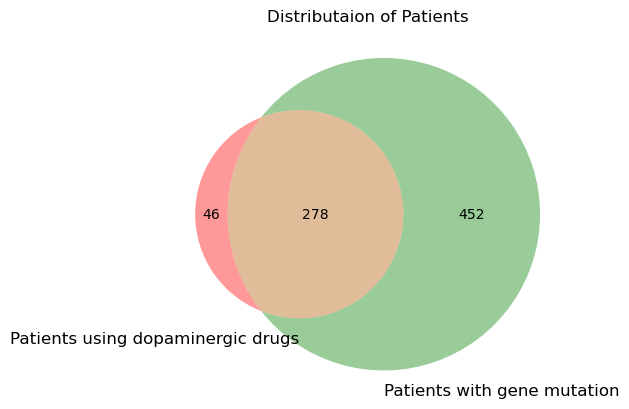

In [8]:
# Rename for convinience 
series1 = patients_using_ddrug['PATNO'].astype(str)
series2 = selected_rows["PATNO"].astype(str)

# Find union, difference, and intersection directly based on their values
union_values = set(series1.values) | set(series2.values)
difference_values = set(series2.values)-set(series1.values) 
intersection_values = set(series1.values) & set(series2.values)

# Create a Venn diagram
venn2(subsets=(len(series1) - len(intersection_values), len(series2) - len(intersection_values), 
               len(intersection_values)),
      set_labels=('Patients using dopaminergic drugs', 'Patients with gene mutation'))

# Display the plot
plt.title('Distributaion of Patients')
plt.show()

In [12]:
union_drugs_mutations = pd.Series(list(union_values))
union_drugs_mutations.to_csv(path1/'union_drugs_mutations.csv')

In [10]:
# Get the current date
current_date = datetime.now().date()

# Print the current date
print("Last update :", current_date)

Last update : 2024-01-29
